In [11]:
import joblib 
import pandas as pd
import numpy as np
import xarray as xr 
import warnings 
import re 
import cmaps 
from gcpy import single_panel 
import matplotlib.pyplot as plt
import seaborn as sns 
import cartopy.crs as ccrs 
from matplotlib.gridspec import GridSpec

import cartopy.feature as cfeature
import matplotlib as mpl 
import regionmask

from src import tools

warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Original simulations 
variable = "EmisNO_Anthro"
w10 = xr.open_dataset("/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_public/GCHP.w10_ref_c48.EmisNO_Anthro.april-august.2000.nc4")
w10_ozoneseason = w10['EmisNO_Anthro'].isel(time=w10.time.dt.month.isin([4,5,6,7,8]))

In [5]:
w10_ozoneseason_mean = w10_ozoneseason.mean(dim='time')

In [6]:
def calculate_regional_mean(da, region, resolution='c48'):
    """
    Calculate the mean and standard deviation for a specific region and month.
    """
    if resolution == 'c48':
        cropped_da = tools.crop_regionmask_ar6_c48(da, region_num=ar6_region[region])
    elif resolution == 'c90':
        cropped_da = tools.crop_regionmask_ar6_c90(da, region_num=ar6_region[region])
    elif resolution == 'latlon':
        cropped_da = crop_regionmask_ar6(da, region_num=ar6_region[region])

    if 'nf' in cropped_da.dims:
        regional_mean = cropped_da.mean(dim=['nf', 'Ydim', 'Xdim'])
    if 'lat' in cropped_da.dims:
        regional_mean = cropped_da.mean(dim=['lat', 'lon'])
    return np.mean(regional_mean*1000 * (14/30)  * 86400 * (365.25)).values #gN/m2/yr

In [7]:
ar6_region = {
        "ENA": 5,
        "EAS": 58,
        "WCE": 17,
    }

In [8]:
ena = calculate_regional_mean(w10_ozoneseason, "ENA", resolution='c48')
wce = calculate_regional_mean(w10_ozoneseason, "WCE", resolution='c48')
eas = calculate_regional_mean(w10_ozoneseason, "EAS", resolution='c48')

In [9]:
# Print mean anthropogenic emissions for each region
print(ena)
print(wce)
print(eas)

0.280806107024285
0.3489212478416114
1.2475802371431441


0


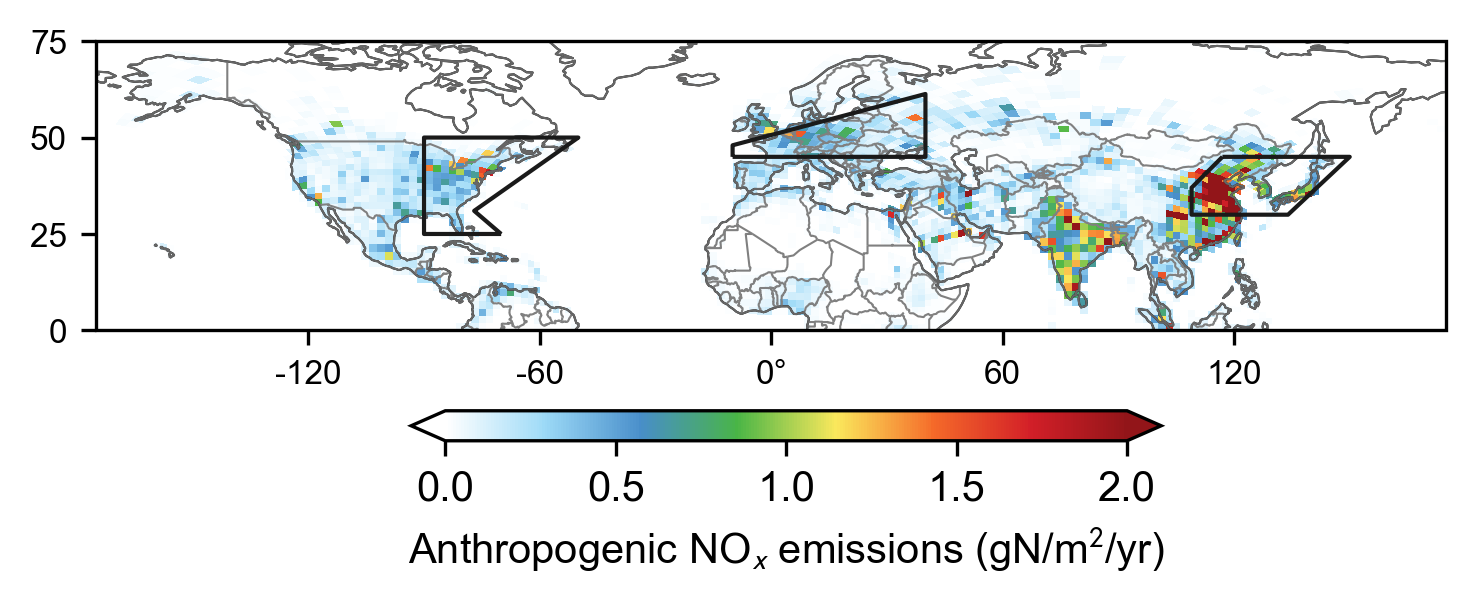

In [10]:
tools.set_matplotlib_font("Arial")
fig_width_in = 5
fig_height_in = 2
fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300)
gs1 = GridSpec(1, 1, top=1.15, bottom=0.20, left=0.09, right=0.99, hspace=0.6, wspace=0.2)
ax = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=0))

for idx, z in enumerate([w10_ozoneseason_mean]):
    print(idx)
    cmap = cmaps.WhiteBlueGreenYellowRed

    plot = single_panel(plot_vals=z*1e10, 
                ax=ax, gridtype="cs", 
                comap=cmap,
                extent=(-175, 175, 0, 75), 
                unit="ppbv",
                log_color_scale=False,
                vmin=0, vmax=2,
                add_cb=False)


    ax.coastlines(color="black", linewidth=0.5)
    country_borders = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale="50m",
        facecolor="none",
    )
    ax.add_feature(country_borders, edgecolor="gray", linewidth=0.5)
    ax.set_extent([-175, 175, 0, 75], crs=ccrs.PlateCarree())

    ax.set_xticks([-120, -60, 0, 60, 120])
    ax.set_xticklabels(
            ['-120', '-60', '0°', '60', '120'], fontsize=8)
    
    ax.set_yticks([0,25,50,75])

    ax.set_yticklabels(
            ['0', '25', '50', '75'], fontsize=8)

    # Add boxes around the IPCC AR6 regions
    ar6 = regionmask.defined_regions.ar6.all
    ar6[5,17].plot(ax=ax,
        add_ocean=False,
        projection=ccrs.PlateCarree(),
        add_label=False,
        line_kws=dict(lw=1)
    )

    # For EAS we use a modified polygon that captures a more homogeneous response
    new_EAS = np.array([[117,45], [109,37], [109,30], [134,30], [134,30], [150,45]])
    new_EAS_region = regionmask.Regions([new_EAS], name="new_EAS")
    new_EAS_region.plot_regions(add_label=False, ax=ax, line_kws=dict(lw=1))

ax.set_title(None)
cbar_ax = fig.add_axes([0.30, 0.25, 0.50, 0.05])  # [left, bottom, width, height]
cbar = fig.colorbar(plot,  
                    cax=cbar_ax, 
                    orientation="horizontal", 
                    shrink=0.50, 
                    label='Anthropogenic NO$_x$ emissions (gN/m$^2$/yr)',
                    extend='both'
                    )

plt.savefig("FigS1_new.png")
plt.show()